#<아이컨택> Team Project
## 이미지 분류를 통한 제주도 여행지 추천
##### #include : 전혜지 박서희 심영민 이재훈 정다연

## 환경 설정

*   구글 드라이브 마운트
*   필요한 라이브러리 import






In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요한 라이브러리 import
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

from IPython.display import Markdown, display
import glob
from PIL import Image

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

##여행 선호도 시각화

*   여행지를 제주도로 선정한 이유
*   전체 만족도 시각화



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/content/drive/MyDrive/satisfaction.csv",encoding = 'CP949')
df.drop('통계분류(2)',axis = 1,inplace = True)
df.columns = list(df.iloc[0][:])
df = df.drop(df.index[0])
df=df.transpose()
df.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
통계분류(1),전체,성별,성별,연령,연령,연령,연령,연령,연령,연령,...,가구원수,가구원수,가구원수,가구소득,가구소득,가구소득,가구소득,가구소득,가구소득,가구소득
서울,78.7,78.4,78.9,77.5,79.9,78.5,78.5,77.5,75,82.4,...,80.2,78.8,78.4,81.1,78.6,77.6,78.3,77.9,79.5,78.9
부산,80.5,79.7,81.3,80.8,81.8,79.6,79.9,79.1,80.7,80.6,...,80.3,79.6,80.7,84.7,80.5,80.6,79.7,78.9,79.2,82.9
대구,76,74.3,77.3,77.5,79.2,77.2,73.5,73.1,75.7,74.8,...,79.2,76.6,75,76.1,76.1,79.1,76.4,73,75.5,77.5
인천,78.1,78.3,77.9,80.3,78.5,78.9,78.8,77.1,76.8,73.6,...,78.1,78.3,78,79.9,77.9,80.2,77.4,80.4,77.7,76.9


In [ ]:
# warning메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 나눔바른고딕 폰트 설치 - [런타임 다시 시작]되면 폰트를 다시 설치해야 한글이 보입니다.
!apt-get install fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.2 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
# 한글폰트 설치하기 위해 필요함
import matplotlib.font_manager as fm

fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rcParams['font.family'] = "NanumBarunGothic"
plt.rcParams['axes.unicode_minus']

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

True

In [ ]:
import numpy as np
arr = pd.to_numeric(df.iloc[1:][1])
arr =arr.sort_values()
arr_y = arr.values
arr_x = np.array(arr.keys())

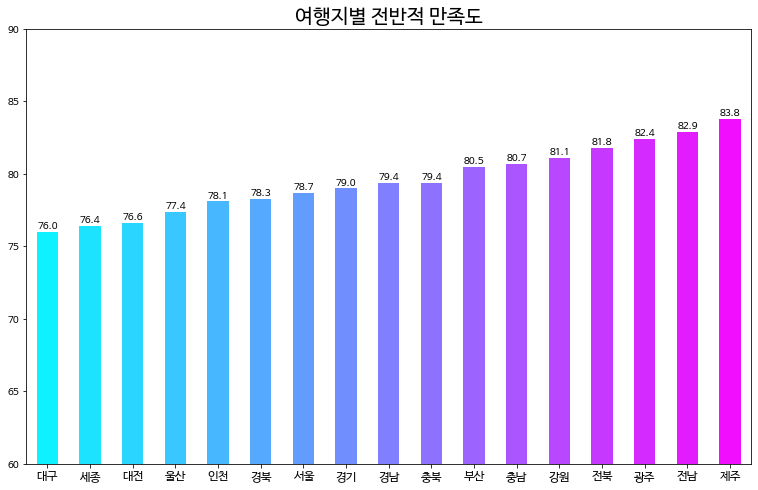

In [ ]:
colors = sns.color_palette('cool',len(arr))
plt.figure(figsize = (13,8))
plt.title("여행지별 전반적 만족도",size = 20)
plt.ylim(60,90)
arr.plot(kind = 'bar',color = colors)
plt.xticks(rotation = 0,size = 12)
for i in range(len(arr_x)):
  plt.text(i,arr_y[i],arr_y[i],horizontalalignment='center',verticalalignment='bottom')

plt.show()

##이미지 전처리


*   카테고리 리스트 생성
*   X에 image, Y에 label을 넣어 라벨링
*   이미지 사이즈 및 스케일 조정 작업
*   train/test set 나눔


In [ ]:
caltech_dir = "/content/drive/MyDrive/project_data/project_data" #img파일 경로
categories = ["낚시","농장", "동굴","레일바이크","미로", "미술관","민속촌",
              "바다","사찰", "산","서핑","섬","성당","숲","스쿠버다이빙","승마",
              "역사","오프로드","요트", "자동차","잠수함","장성","정원","지질",
              "짚라인","차","초콜릿","카누","카트","캐릭터","패러글라이딩",
              "폭포","피아노","해녀"] #모든 카테고리

nb_classes = len(categories) #카테고리 개수

image_w = 128 #이미지 가로
image_h = 128 #이미지 세로

pixels = image_h * image_w *3 #이미지 픽셀

X = [] # feature
Y = [] # taget

#라벨링, 이미지 dir만들어줌
for idx,cat in enumerate(categories):
  label = [0 for i in range(nb_classes)]
  label[idx] = 1

  image_dir = caltech_dir +"/" + cat
  files = glob.glob(image_dir+"/*.jpg")

  for i,f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w,image_h))
    data = np.asarray(img).astype('float32')/255
    X.append(data)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

#train과 test set으로 나눔
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) 


##모델 생성

*   model0 : 기본 모델 설명
*   model1 : 은닉층 추가
*   model2 : 컨볼루션, 폴링 레이어 추가
*   model3 : inceptionV3 임베딩


###(0)CNN모델

In [ ]:
#model0 생성
model0 = keras.Sequential()
model0.add(keras.layers.Conv2D(32,(3,3),padding = "same",input_shape = X_train.shape[1:],activation = 'relu'))
model0.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model0.add(keras.layers.Dropout(0.25))

model0.add(keras.layers.Flatten())

model0.add(keras.layers.Dense(128,activation = 'relu'))
model0.add(keras.layers.Dense(64,activation = 'relu'))

model0.add(keras.layers.Dense(nb_classes,activation = 'softmax'))

# model0 요약
model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_189 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               16777344  
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                      

In [ ]:
#model0 compile
model0.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [ ]:
# train데이터로 학습시킴
history = model0.fit(X_train,Y_train,batch_size = 32,epochs = 30,validation_split=0.25)

In [ ]:
#손실, 정확도
test_loss,test_acc = model0.evaluate(X_test,Y_test)
print('\n테스트 정확도:', test_acc*100)

75/75 [==============================] - 1s 9ms/step - loss: 4.9313 - accuracy: 0.3793

테스트 정확도: 37.933918833732605


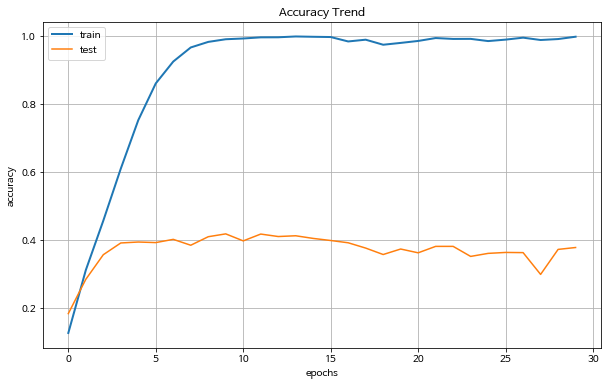

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linewidth="2")
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'])
plt.grid()
plt.show()

###(1) 은닉층 추가 모델

In [ ]:
#model1 생성
model1 = keras.Sequential()
model1.add(keras.layers.Conv2D(32,(3,3),padding = "same",input_shape = X_train.shape[1:],activation = 'relu'))
model1.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model1.add(keras.layers.Dropout(0.25))

model1.add(keras.layers.Conv2D(64,(3,3),padding = "same",activation = 'relu'))
model1.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model1.add(keras.layers.Dropout(0.25))

model1.add(keras.layers.Flatten())

model1.add(keras.layers.Dense(1024,activation = 'relu'))
model1.add(keras.layers.Dense(512,activation = 'relu'))
model1.add(keras.layers.Dense(256,activation = 'relu'))
model1.add(keras.layers.Dense(128,activation = 'relu'))
model1.add(keras.layers.Dense(64,activation = 'relu'))


model1.add(keras.layers.Dense(nb_classes,activation = 'softmax'))

# model1 요약
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)       

In [ ]:
#model compile
model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [ ]:
# train데이터로 학습시킴
history = model1.fit(X_train,Y_train,batch_size = 32,epochs = 40,validation_split=0.25)

In [ ]:
#손실, 정확도
test_loss,test_acc = model1.evaluate(X_test,Y_test)
print('\n테스트 정확도:', test_acc*100)

75/75 [==============================] - 1s 12ms/step - loss: 4.0695 - accuracy: 0.4207

테스트 정확도: 42.07444489002228


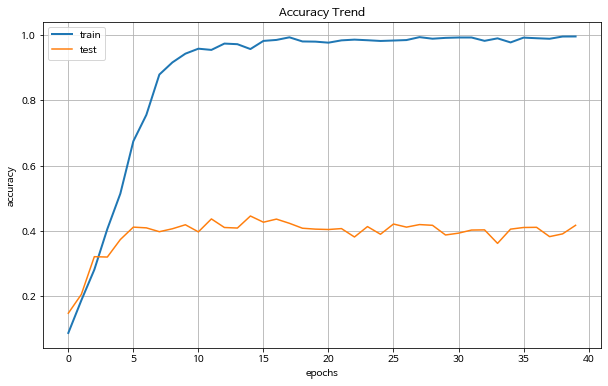

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linewidth="2")
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'])
plt.grid()
plt.show()

###(2) 컨볼루션 레이어, 폴링 레이어 추가 모델

In [ ]:
#model2 생성
model2 = keras.Sequential()
model2.add(keras.layers.Conv2D(32,(3,3),padding = "same",input_shape = X_train.shape[1:],activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(64,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(128,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(128,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(256,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(256,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(512,(3,3),padding = "same",activation = 'relu'))
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128,activation = 'relu'))


model2.add(keras.layers.Dense(nb_classes,activation = 'softmax'))

# model2 요약
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 64)       

In [ ]:
#model compile
model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [ ]:
# train데이터로 학습시킴
history = model2.fit(X_train,Y_train,batch_size = 32,epochs = 50,validation_split=0.25)

In [ ]:
#손실, 정확도
test_loss,test_acc = model2.evaluate(X_test,Y_test)
print('\n테스트 정확도:', test_acc*100)

75/75 [==============================] - 1s 14ms/step - loss: 1.9769 - accuracy: 0.5483

테스트 정확도: 54.83061671257019


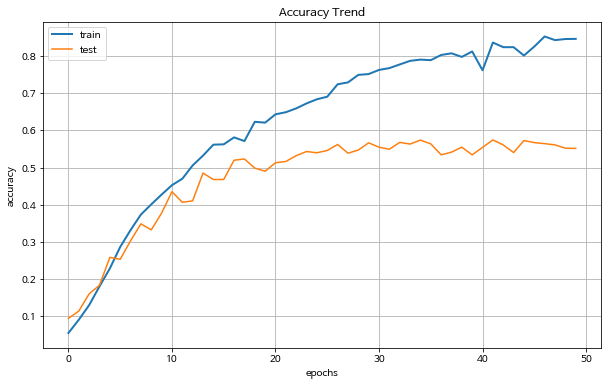

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linewidth="2")
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'])
plt.grid()
plt.show()

###(3)inceptionV3 임베딩

In [ ]:
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model

In [ ]:
pre_trained_model = InceptionV3(input_shape=(128, 128, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.summary()

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(128, activation='relu')(my_layer)
my_layer = layers.Dense(nb_classes, activation = 'softmax')(my_layer)

In [ ]:
model3 = Model(pre_trained_model.input, my_layer)

model3.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
history = model3.fit(X_train, Y_train, epochs = 50, validation_split=0.25)

In [ ]:
test_loss,test_acc = model3.evaluate(X_test,Y_test)
print('\n테스트 정확도:', test_acc*100)

75/75 [==============================] - 2s 31ms/step - loss: 0.0249 - accuracy: 0.3492

테스트 정확도: 34.92262661457062


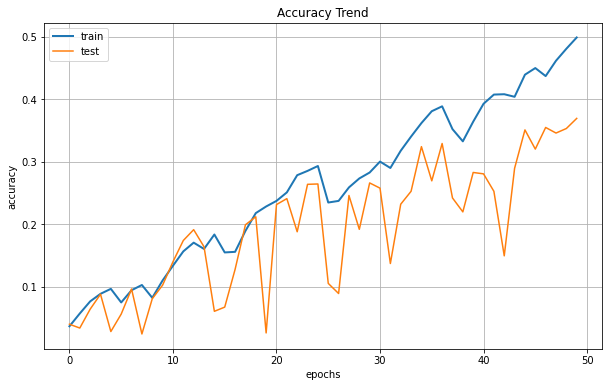

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linewidth="2")
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'])
plt.grid()
plt.show()

##모델비교

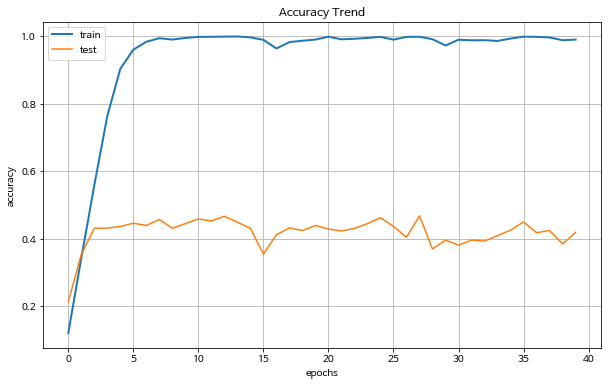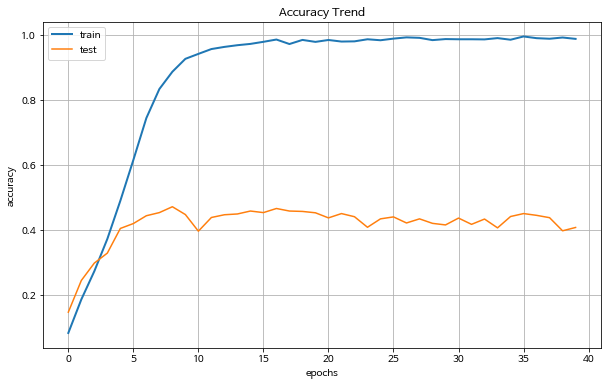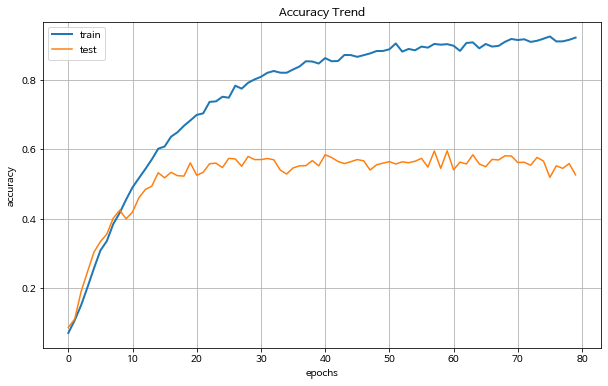

##내 이미지로 찾기

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
      name=fn


Saving beachtest.jpg to beachtest.jpg


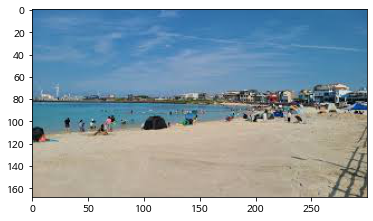

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img=mpimg.imread(name)
plt.imshow(img)

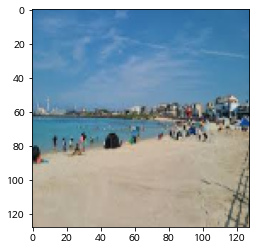

In [ ]:
import cv2
img = cv2.imread(name)
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)  

In [ ]:
y_hat0 = model0.predict(img[np.newaxis ,:,:])
#print(y_hat0)
category = categories[y_hat0.argmax()]
print('model0(기본) 판정 : ',categories[y_hat0.argmax()])

y_hat1 = model1.predict(img[np.newaxis ,:,:])
#print(y_hat1)
category = categories[y_hat1.argmax()]
print('model1(은닉층) 판정 : ',categories[y_hat1.argmax()])

y_hat2 = model2.predict(img[np.newaxis ,:,:])
#print(y_hat2)
category = categories[y_hat2.argmax()]
print('model2(레이어) 판정 : ',categories[y_hat2.argmax()])

# y_hat3 = model3.predict(img[np.newaxis ,:,:])
# #print(y_hat3)
# category = categories[y_hat3.argmax()]
# print('model3(inceptionV3) 판정 : ',categories[y_hat3.argmax()])

model0(기본) 판정 :  요트
model1(은닉층) 판정 :  미술관
model2(레이어) 판정 :  바다


##해당 위치 나타내기

In [ ]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

mc = MarkerCluster()
file = "/content/drive/MyDrive/location.csv"
df = pd.read_csv(file, encoding='cp949')

df.head()

,name,theme,location,Latitude,Longitude
0,마라도,섬,제주 서귀포시 대정읍 가파리 600,33.118537,126.267348
1,우도,섬,제주 제주시 우도면,33.506491,126.953361
2,협재해수욕장,바다,제주 제주시 한림읍 협재리 2497-1,33.392440,126.239036
3,월정리해변,바다,제주 제주시 구좌읍 월정리 33-3,33.555118,126.798624
4,용머리해안,바다,제주 서귀포시 안덕면 사계리 112-3,33.232861,126.314063


In [ ]:
df =df.groupby('theme').get_group(category)

df.head()

,name,theme,location,Latitude,Longitude
2,협재해수욕장,바다,제주 제주시 한림읍 협재리 2497-1,33.392440,126.239036
3,월정리해변,바다,제주 제주시 구좌읍 월정리 33-3,33.555118,126.798624
4,용머리해안,바다,제주 서귀포시 안덕면 사계리 112-3,33.232861,126.314063
5,금능해수욕장,바다,제주 제주시 한림읍 금능리,33.359857,126.246073
126,함덕 해수욕장,바다,제주특별자치도 제주시 조천읍 신북로,33.538670,126.645843


In [ ]:
#마커
map = folium.Map(location = [33.3080, 126.57423], zoom_start=10) #제주도 서귀포시로 열기

for name in df.index:
  lat = df.loc[name, 'Latitude']
  lng = df.loc[name, 'Longitude']
  mc.add_child(
      folium.Marker(location=[lat, lng],popup = df.loc[name,'name'],tooltip = df.loc[name,'name'])
            
  )
map.add_child(mc)
map